In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Fri Jan 12 17:20:18 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   24C    P8    17W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_vae_encoder import Encoder
from model.latent_layer.sampling_uniform_lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.0202789306640625
encoder.convs 5.989013671875
encoder.linear 0.0312652587890625
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.12-5/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 39452
-rw-rw-r-- 1 scpark scpark   216740  1월 12 17:20 events.out.tfevents.1705047495.GPUSVR01
-rw-rw-r-- 1 scpark scpark 38023101  1월 12 17:18 save_0
-rw-rw-r-- 1 scpark scpark   435236  1월 12 17:18 events.out.tfevents.1705047255.GPUSVR01
-rw-rw-r-- 1 scpark scpark   685412  1월 12 17:14 events.out.tfevents.1705046894.GPUSVR01
-rw-rw-r-- 1 scpark scpark   488132  1월 12 17:08 events.out.tfevents.1705046628.GPUSVR01
-rw-rw-r-- 1 scpark scpark   434468  1월 12 17:03 events.out.tfevents.1705046390.GPUSVR01
-rw-rw-r-- 1 scpark scpark    98468  1월 12 16:59 events.out.tfevents.1705046317.GPUSVR01


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


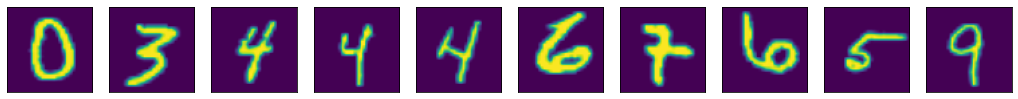

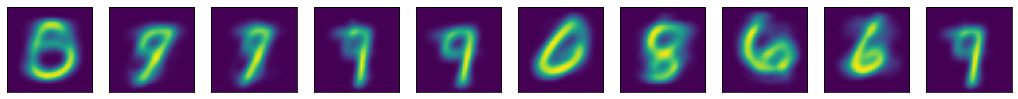

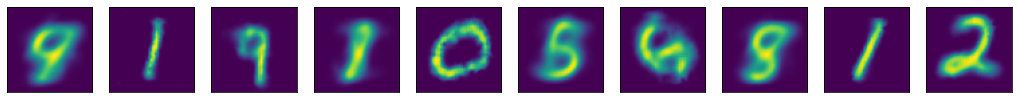

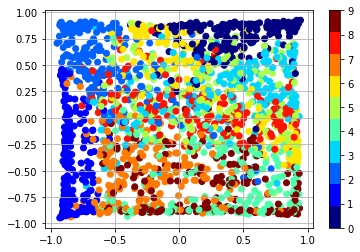

123001
lse_loss 0.0044693127274513245
recon_loss 0.1571483165025711
123002
lse_loss -0.00031614306499250233
recon_loss 0.15170088410377502
123003
lse_loss 0.012303842231631279
recon_loss 0.15194374322891235
123004
lse_loss 0.10088161379098892
recon_loss 0.14820241928100586
123005
lse_loss 0.013026310130953789
recon_loss 0.15451759099960327
123006
lse_loss 0.07375466823577881
recon_loss 0.15454934537410736
123007
lse_loss -0.06230414658784866
recon_loss 0.1500999629497528
123008
lse_loss -0.00475879292935133
recon_loss 0.15859206020832062
123009
lse_loss 0.07351528108119965
recon_loss 0.15936359763145447
123010
lse_loss 0.02371148020029068
recon_loss 0.14510709047317505
123011
lse_loss 0.009155180305242538
recon_loss 0.1536918580532074
123012
lse_loss 0.05615418031811714
recon_loss 0.14926940202713013
123013
lse_loss 0.044529933482408524
recon_loss 0.16062161326408386
123014
lse_loss 0.017317064106464386
recon_loss 0.15301722288131714
123015
lse_loss 0.06863592565059662
recon_loss 0.173

lse_loss 0.059567201882600784
recon_loss 0.1671285331249237
123126
lse_loss 0.0483456514775753
recon_loss 0.15945595502853394
123127
lse_loss 0.07277442514896393
recon_loss 0.15331870317459106
123128
lse_loss 0.0025839353911578655
recon_loss 0.1535290777683258
123129
lse_loss 0.07334315776824951
recon_loss 0.14829963445663452
123130
lse_loss 0.061944495886564255
recon_loss 0.15635806322097778
123131
lse_loss 0.0825369730591774
recon_loss 0.15207473933696747
123132
lse_loss 0.05544600263237953
recon_loss 0.1492094099521637
123133
lse_loss 0.06207220256328583
recon_loss 0.1468886137008667
123134
lse_loss 0.04498634859919548
recon_loss 0.15564599633216858
123135
lse_loss -0.008234054781496525
recon_loss 0.14490027725696564
123136
lse_loss 0.0012920789886265993
recon_loss 0.16030046343803406
123137
lse_loss 0.023657582700252533
recon_loss 0.15099649131298065
123138
lse_loss 0.028020543977618217
recon_loss 0.1535756140947342
123139
lse_loss 0.012358675710856915
recon_loss 0.1524530649185180

123248
lse_loss 0.013633135706186295
recon_loss 0.15402017533779144
123249
lse_loss -0.028805429115891457
recon_loss 0.16652020812034607
123250
lse_loss 0.002669539535418153
recon_loss 0.16338691115379333
123251
lse_loss 0.06620161235332489
recon_loss 0.1513242870569229
123252
lse_loss -0.035555996000766754
recon_loss 0.14575999975204468
123253
lse_loss 0.01795349270105362
recon_loss 0.15969352424144745
123254
lse_loss -0.037391215562820435
recon_loss 0.16050711274147034
123255
lse_loss 0.023166386410593987
recon_loss 0.15933719277381897
123256
lse_loss -0.0070677148178219795
recon_loss 0.1494382917881012
123257
lse_loss 0.020590180531144142
recon_loss 0.16296517848968506
123258
lse_loss 0.09496613591909409
recon_loss 0.14939197897911072
123259
lse_loss -0.016600271686911583
recon_loss 0.16080419719219208
123260
lse_loss 0.021408293396234512
recon_loss 0.15241456031799316
123261
lse_loss 0.026506418362259865
recon_loss 0.15033844113349915
123262
lse_loss -0.05252980440855026
recon_loss

123371
lse_loss 0.009918018244206905
recon_loss 0.14759978652000427
123372
lse_loss -0.03445560485124588
recon_loss 0.16150449216365814
123373
lse_loss 0.07648196071386337
recon_loss 0.1633918285369873
123374
lse_loss 0.024697305634617805
recon_loss 0.15638503432273865
123375
lse_loss -0.008870432153344154
recon_loss 0.1505340337753296
123376
lse_loss 0.025045491755008698
recon_loss 0.14401066303253174
123377
lse_loss -0.00943145900964737
recon_loss 0.1509440839290619
123378
lse_loss 0.03563584387302399
recon_loss 0.151715487241745
123379
lse_loss 0.09290072321891785
recon_loss 0.17300081253051758
123380
lse_loss 0.07671567052602768
recon_loss 0.14735524356365204
123381
lse_loss 0.06575963646173477
recon_loss 0.1646513193845749
123382
lse_loss 0.0651841089129448
recon_loss 0.15237513184547424
123383
lse_loss 0.03829728066921234
recon_loss 0.14592993259429932
123384
lse_loss -0.03536004200577736
recon_loss 0.15203920006752014
123385
lse_loss -0.013084782287478447
recon_loss 0.1588740944

123493
lse_loss 0.0029418175108730793
recon_loss 0.1551121324300766
123494
lse_loss 0.023449724540114403
recon_loss 0.15597043931484222
123495
lse_loss 0.04205535724759102
recon_loss 0.14959608018398285
123496
lse_loss 0.10815292596817017
recon_loss 0.15348529815673828
123497
lse_loss 0.11431203782558441
recon_loss 0.1630617380142212
123498
lse_loss 0.049901098012924194
recon_loss 0.1465304046869278
123499
lse_loss 0.08984176069498062
recon_loss 0.15716509521007538
123500
lse_loss -0.004192030057311058
recon_loss 0.1537720263004303
123501
lse_loss 0.054255492985248566
recon_loss 0.15858039259910583
123502
lse_loss -0.03195090591907501
recon_loss 0.1598777025938034
123503
lse_loss 0.05319485068321228
recon_loss 0.15809890627861023
123504
lse_loss 0.09890404343605042
recon_loss 0.16940739750862122
123505
lse_loss 0.07033608108758926
recon_loss 0.15097758173942566
123506
lse_loss 0.008848530240356922
recon_loss 0.1614084094762802
123507
lse_loss 0.017061812803149223
recon_loss 0.151817888

123617
lse_loss 0.03556087985634804
recon_loss 0.1576281487941742
123618
lse_loss 0.06047007441520691
recon_loss 0.15389256179332733
123619
lse_loss 0.01319140661507845
recon_loss 0.15203242003917694
123620
lse_loss -0.00031556416070088744
recon_loss 0.14598186314105988
123621
lse_loss 0.02566506341099739
recon_loss 0.1509285718202591
123622
lse_loss -0.019209573045372963
recon_loss 0.15894100069999695
123623
lse_loss 0.06710045784711838
recon_loss 0.14391665160655975
123624
lse_loss -0.05030715838074684
recon_loss 0.15849199891090393
123625
lse_loss 0.07557685673236847
recon_loss 0.1576457917690277
123626
lse_loss 0.005821106024086475
recon_loss 0.14424416422843933
123627
lse_loss 0.06200644373893738
recon_loss 0.16192685067653656
123628
lse_loss -0.041568778455257416
recon_loss 0.13899125158786774
123629
lse_loss -0.0034490826074033976
recon_loss 0.15189531445503235
123630
lse_loss -0.0047968849539756775
recon_loss 0.15680521726608276
123631
lse_loss 0.06999818980693817
recon_loss 0.

123740
lse_loss 0.011677692644298077
recon_loss 0.16465261578559875
123741
lse_loss -0.007707563694566488
recon_loss 0.15200456976890564
123742
lse_loss -0.014664022251963615
recon_loss 0.14674530923366547
123743
lse_loss 0.04447377100586891
recon_loss 0.13994379341602325
123744
lse_loss 0.016897577792406082
recon_loss 0.15056167542934418
123745
lse_loss 0.08735591173171997
recon_loss 0.15939050912857056
123746
lse_loss 0.0330011323094368
recon_loss 0.1639021784067154
123747
lse_loss 0.01809052750468254
recon_loss 0.1482946127653122
123748
lse_loss 0.02762596681714058
recon_loss 0.1588791012763977
123749
lse_loss 0.042980920523405075
recon_loss 0.14947953820228577
123750
lse_loss 0.103291817009449
recon_loss 0.15421907603740692
123751
lse_loss 0.080008864402771
recon_loss 0.14905905723571777
123752
lse_loss 0.03671908378601074
recon_loss 0.15866675972938538
123753
lse_loss 0.08201320469379425
recon_loss 0.15611299872398376
123754
lse_loss -0.02266783080995083
recon_loss 0.1516961902379

123863
lse_loss -0.024162637069821358
recon_loss 0.14994317293167114
123864
lse_loss -0.051458533853292465
recon_loss 0.15224073827266693
123865
lse_loss -0.011847863905131817
recon_loss 0.15760090947151184
123866
lse_loss 0.01466246135532856
recon_loss 0.13705015182495117
123867
lse_loss 0.015028294175863266
recon_loss 0.16161879897117615
123868
lse_loss 0.029345665127038956
recon_loss 0.14933888614177704
123869
lse_loss 0.04793816804885864
recon_loss 0.14765605330467224
123870
lse_loss 0.009188738651573658
recon_loss 0.1589760035276413
123871
lse_loss 0.026824669912457466
recon_loss 0.15460294485092163
123872
lse_loss 0.016664549708366394
recon_loss 0.15702514350414276
123873
lse_loss 0.14447055757045746
recon_loss 0.1408853828907013
123874
lse_loss -0.021120332181453705
recon_loss 0.14162300527095795
123875
lse_loss 0.00785197876393795
recon_loss 0.14474424719810486
123876
lse_loss 0.034721195697784424
recon_loss 0.1571204662322998
123877
lse_loss -0.048721589148044586
recon_loss 0.

KeyboardInterrupt: 

In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=1000, sigma=8e-2)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-2)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z_mean'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        